In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score
import itertools

In [14]:
# Hyper parameter tuning
file_name = {3: "Rolling3Games.csv",
             5: "Rolling5Games.csv",
             9:"Rolling9Games.csv",
             15: "Rolling15Games.csv",
             20: "Rolling20Games.csv"}
max_features = 12

In [8]:
col_dict = {'FGM_HOME': 0, 'FGA_HOME': 1, 'FG3M_HOME': 2, 'FTM_HOME': 3, 'FTA_HOME': 4, 'OREB_HOME': 5, 'DREB_HOME': 6,
            'AST_HOME': 7, 'STL_HOME': 8, 'TOV_HOME': 9, 'PF_HOME': 10, 'PTS_HOME': 11, 'FGM_AWAY': 12, 'FGA_AWAY': 13,
            'FG3M_AWAY': 14, 'FTM_AWAY': 15, 'FTA_AWAY': 16, 'OREB_AWAY': 17, 'DREB_AWAY': 18, 'AST_AWAY': 19,
            'STL_AWAY': 20, 'TOV_AWAY': 21, 'PF_AWAY': 22, 'PTS_AWAY': 23}

In [9]:
def get_input_data(file_name):        
    # for easier reading np
    np.set_printoptions(precision=3,suppress=True)
    with open(f'../../data/{file_name}', 'r') as f: 
        temp = np.genfromtxt(f,delimiter=',', skip_header = 1)
    
    #split feature matrix and label vector
    X = temp[:, 1:]
    y = temp[:, 0]
    
    return X, y

In [13]:
from sklearn.model_selection import train_test_split

# Split into train, test and standardize data
def preprocess_data(X,y):
    # split training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
    
    # Scaling Data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)  
    
    return X_train, X_test, y_train, y_test 

In [11]:
def logreg_feat_selection(X_train, X_test, y_train, y_test, max_features):
    max_acc = 0
    max_comb = ()
    acc_dict = {}

    for num_features in range(1,max_features+1):
        acc_dict[num_features] = []
        for comb in itertools.combinations(range(12), num_features):
            iter_indices = list(comb)
            iter_indices += [i+12 for i in iter_indices]
            X_train_pair = X_train[:,iter_indices]
            X_test_pair = X_test[:,iter_indices]
            clf = LogisticRegression(fit_intercept=True).fit(X_train_pair, y_train)
            y_pred = clf.predict(X_test_pair)
            iter_acc = accuracy_score(y_pred, y_test)
            
            acc_dict[num_features].append(iter_acc)
            
            if iter_acc > max_acc:
                max_comb = comb
                max_acc = iter_acc
                
    return max_acc, max_comb, acc_dict

In [16]:
rolling_acc_dict = {}
max_acc_dict = {}
max_comb_dict = {}
for num_games, f_name in file_name.items():
    X,y = get_input_data(f_name)
    X_train, X_test, y_train, y_test = preprocess_data(X,y)
    max_acc, max_comb, acc_dict = logreg_feat_selection(X_train, X_test, y_train, y_test, max_features)
    rolling_acc_dict[num_games] = acc_dict
    max_acc_dict[num_games] = max_acc
    max_comb_dict[num_games] = max_comb
    print(num_games)
    print(max_acc)
    print(max_comb)


3
0.6120640365923384
(0, 1, 2, 3, 4, 6, 9)
5
0.6232132647226987
(0, 1, 2, 5, 6, 7, 8, 9)
9
0.6535162950257289
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
15
0.6449399656946827
(1, 2, 4, 5, 6, 9, 11)
20
0.6420811892510006
(0, 1, 3, 5, 6, 8, 9, 10, 11)


In [17]:
import matplotlib.pyplot as plt

In [26]:
max_acc_dict.keys()

dict_keys([3, 5, 9, 15, 20])

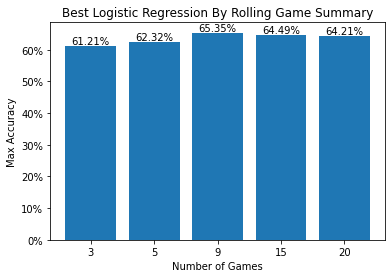

In [51]:
rolling_games = [str(k) for k in max_acc_dict.keys()]
max_acc_perc = [i*100 for i in max_acc_dict.values()]
fig, ax = plt.subplots()
bars = ax.bar(rolling_games,max_acc_perc)
plt.xlabel("Number of Games")
plt.ylabel("Max Accuracy")
plt.title("Best Logistic Regression By Rolling Game Summary")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.bar_label(bars, labels=['{:.2%}'.format(i) for i in max_acc_dict.values()])

In [70]:
heat_map_arr = []
for num_games in file_name.keys():
    num_games_max = []
    for i in range(1,max_features+1):
        num_games_max.append(round(max(rolling_acc_dict[num_games][i]),3))
    heat_map_arr.append(num_games_max)

Text(0.5, 1.0, 'Logistic Regression Accuracy Heatmap')

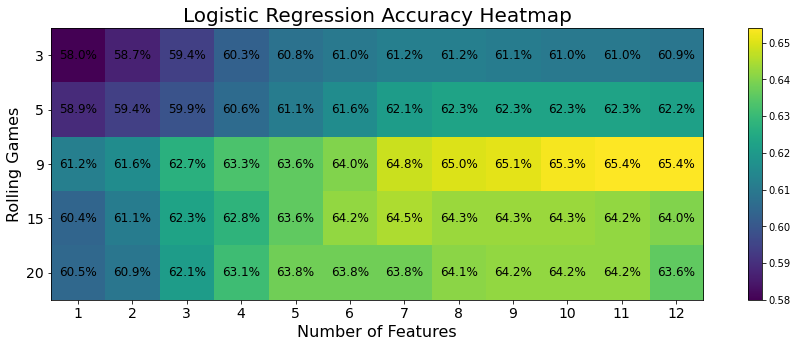

In [83]:
fig,ax = plt.subplots(figsize=(16,5))
im = ax.imshow(np.array(heat_map_arr))
ax.set_yticks(np.arange(len(file_name.keys())),labels=file_name.keys(),size=14)
ax.set_xticks(np.arange(max_features),labels=[i for i in range(1,max_features+1)],size=14)

cbar = ax.figure.colorbar(im, ax = ax)

for i in range(len(file_name.keys())):
    for j in range(max_features):
        text = ax.text(j, i, '{:.1%}'.format(heat_map_arr[i][j]),
                       ha="center", va="center", color="black", size=12)
ax.set_ylabel("Rolling Games", size=16)
ax.set_xlabel("Number of Features", size=16)
ax.set_title("Logistic Regression Accuracy Heatmap",size=20)

In [52]:
rolling_acc_dict

{3: {1: [0.5803316180674671,
   0.5740423098913665,
   0.5728987993138936,
   0.5740423098913665,
   0.5740423098913665,
   0.5740423098913665,
   0.5766152086906804,
   0.5763293310463122,
   0.5726129216695255,
   0.5740423098913665,
   0.5740423098913665,
   0.5797598627787307],
  2: [0.5866209262435678,
   0.5831903945111492,
   0.5797598627787307,
   0.5803316180674671,
   0.5786163522012578,
   0.577472841623785,
   0.5746140651801029,
   0.5771869639794168,
   0.5783304745568897,
   0.5797598627787307,
   0.5780445969125214,
   0.5731846769582619,
   0.5740423098913665,
   0.5740423098913665,
   0.5740423098913665,
   0.5743281875357347,
   0.5740423098913665,
   0.5706117781589479,
   0.5734705546026301,
   0.5740423098913665,
   0.5866209262435678,
   0.5766152086906804,
   0.5740423098913665,
   0.5726129216695255,
   0.5806174957118353,
   0.5800457404230989,
   0.5783304745568897,
   0.5789022298456261,
   0.577472841623785,
   0.5851915380217267,
   0.5726129216695255,
   